In [1]:
# Import all necessery libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Statistics
from scipy import stats
from scipy.stats import boxcox

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

#ML
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso,LinearRegression,Ridge,ElasticNetCV,RidgeCV,LassoCV
from sklearn.metrics import r2_score,mean_squared_error



# read dataset and simple information
train=pd.read_csv('./kaggle-house-prices-advanced-regression-techniques/data0/train.csv')
test=pd.read_csv('./kaggle-house-prices-advanced-regression-techniques/data0/test.csv')
print(train.head())
print(train.shape)
print(train.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

### Data preprocess

             num_miss  missing_perc
PoolQC           1453           1.0
MiscFeature      1406           1.0
Alley            1369           0.9
Fence            1179           0.8
FireplaceQu       690           0.5
(1460, 74)
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
SalePrice          0
dtype: int64
Inde

D:\anaconda\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\JAYTIN~1\AppData\Local\Temp/ipykernel_37804/247027578.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_cols[feature] = imputer.fit_transform(cat_cols[feature].values.reshape(-1,1))
C:\Users\JAYTIN~1\AppData\Local\Temp/ipykernel_37804/247027578.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

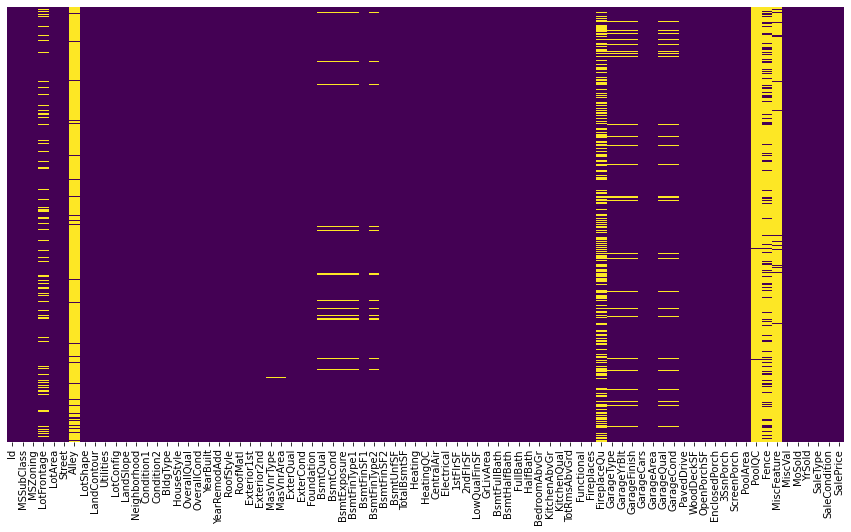

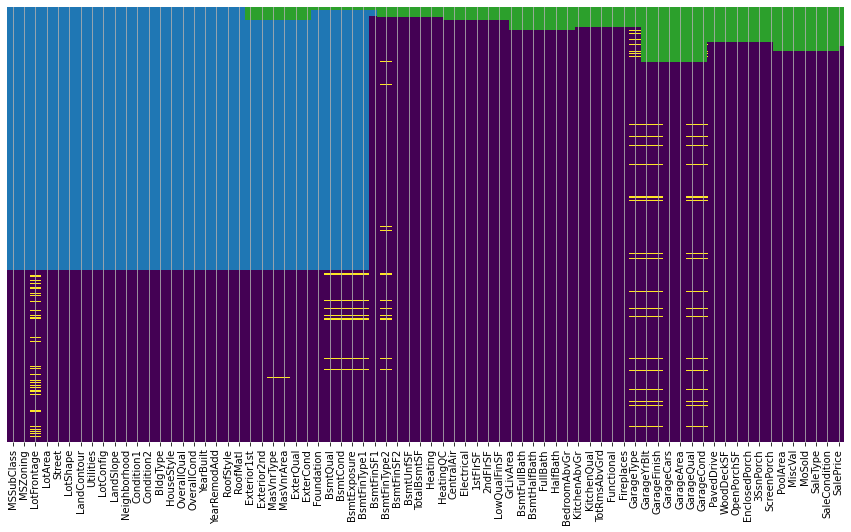

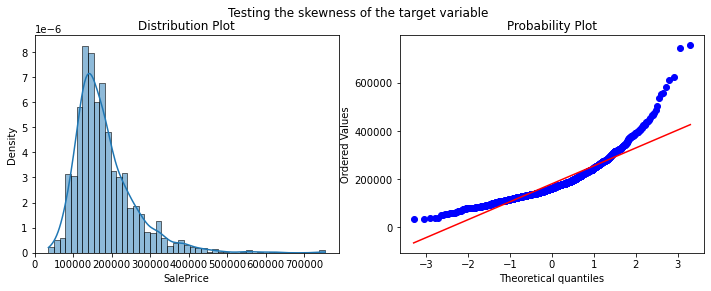

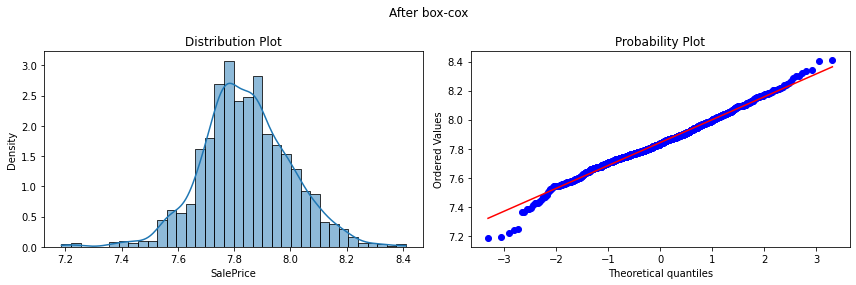

In [2]:

#data cleaning
#let's deal with missing value(NaNs in the dataset)
plt.figure(figsize=(15,8))
sns.heatmap(train.isnull(),yticklabels=False, cbar = False, cmap="viridis")     #missing value can be shown as yellow
#plt.show()

#I will directly drop the colomns that the missing value consist of more than 20%
missing_val=pd.DataFrame(train.isnull().sum()[train.isnull().sum()!=0].sort_values(ascending=False)).rename(columns={0:'num_miss'})
missing_val['missing_perc'] = (missing_val/train.shape[0]).round(1)
missing_val = missing_val.query('missing_perc>0.2')
print(missing_val)
train.drop(columns=['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu','YrSold'],axis=1,inplace=True)
print(train.shape)
plt.figure(figsize=(15,8))
sns.heatmap(train.isnull(),yticklabels=False, cbar = False, cmap="viridis")     #missing value can be shown as yellow
#plt.show()


#now we need to divide the dataset into two groups(numerical features and categorical features)
num_cols=train.select_dtypes(include=['number'])
cat_cols=train.select_dtypes(include=['object'])

# convert year cols to number of years since
# mask=num_cols.columns.str.contains('^Year|Yr')
# year_cols=num_cols.loc[:,mask].copy()
# num_cols[year_cols.columns]=year_cols.apply(lambda x:2021-x)
# train[year_cols.columns]=year_cols.apply(lambda x:2021-x)


#next we are going to fill in the NAs
print(num_cols.isna().sum())
num_cols.MasVnrArea.hist(bins = 50)
num_cols.GarageYrBlt.hist(bins = 50)
a = num_cols.GarageYrBlt.mean()
num_cols.LotFrontage.hist(bins = 50)
b = num_cols.LotFrontage.median()
num_cols.MasVnrArea.fillna(0, inplace = True)
num_cols.GarageYrBlt.fillna(a, inplace = True)
num_cols.LotFrontage.fillna(b, inplace = True)
train.MasVnrArea.fillna(0, inplace = True)
train.GarageYrBlt.fillna(a, inplace = True)
train.LotFrontage.fillna(b, inplace = True)

#category variables NAs
cat_cols_missing=cat_cols.columns[cat_cols.isnull().any()]                #return index
print(cat_cols_missing)
imputer=SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
for feature in cat_cols_missing:
     cat_cols[feature] = imputer.fit_transform(cat_cols[feature].values.reshape(-1,1))
     train[feature] = imputer.fit_transform(train[feature].values.reshape(-1,1))
print(cat_cols.nunique().sort_values(ascending = False))
le=LabelEncoder()                   #label encoding(one hot encoding/count encoding/target encoding?)any difference?
for feature in cat_cols.columns:
    cat_cols[feature]=le.fit_transform(cat_cols[feature])
    train[feature]=le.fit_transform(train[feature])

#now deal with the target value
plt.figure(figsize=(12,4))
plt.suptitle("Testing the skewness of the target variable")
# Distribution Plot
plt.subplot(1,2,1)
sns.histplot(train["SalePrice"],stat="density",kde=True)
plt.title('Distribution Plot')
# Probability Plot
plt.subplot(1,2,2)
stats.probplot(train['SalePrice'],plot=plt)
#plt.tight_layout()
#plt.show()
#plt.clf()

#we can see that there is skewness,a box-cox transform is need
target=train['SalePrice']
train['SalePrice'],lambda0=boxcox(target,lmbda=None,alpha=None)
plt.figure(figsize=(12,4))
plt.suptitle("After box-cox")

# Distribution Plot
plt.subplot(1,2,1)
sns.histplot(train["SalePrice"],stat="density",kde=True)
plt.title('Distribution Plot')

# Probability Plot
plt.subplot(1,2,2)
stats.probplot(train['SalePrice'],plot=plt)
plt.tight_layout()
#plt.show()          #now better
#plt.clf()

### Simple LR

In [3]:
train_1 = train

#finally stantardlize the training data
train_std1 = (train_1-train_1.mean(axis=0)/train_1.std(axis=0))
#After data preprocessing showed above, we try to do regression now.
Y = train_std1['SalePrice']
X = train_std1.iloc[:,:-1]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [4]:
import statsmodels.api as sm
res = sm.OLS(Y_train,X_train).fit()
print(res.rsquared)
r2_score(Y_test,res.predict(X_test))

0.9047983872629086


0.6701199290378239

In [5]:
sig_data = X[res.params[res.pvalues<0.05].index.values]
X_train_sig,X_test_sig,Y_train_sig,Y_test_sig=train_test_split(sig_data,Y,test_size=0.2,random_state=0)
res = sm.OLS(Y_train_sig,X_train_sig).fit()
r2_score(Y_test_sig,res.predict(X_test_sig))

0.6784723229911027

In [6]:
# linreg = LinearRegression()
# linreg.fit(X_train,Y_train)
# print("Training set score:{:.2f}".format(linreg.score(X_train,Y_train)))
# print("Test set score:{:.2f}".format(linreg.score(X_test,Y_test)))
# print("the intercept:",linreg.intercept_)
# coeff_df=pd.DataFrame(linreg.coef_,X.columns,columns=['Coefficient'])
# print("the coefficient:\n",coeff_df)
# pred=linreg.predict(X_test)        #bad

### using lasso and ridge to test the dataset

In [7]:
#let's try LASSO and ridge
#try different parameters
pd.set_option('display.max_columns', None)
#use cv to find the best parameter
ridge_model = RidgeCV()
ridge = ridge_model.fit(X_train, Y_train)
print("ridge training set scores："+str(r2_score(Y_train,ridge_model.predict(X_train))))
print("ridge testing set scores："+str(r2_score(Y_test,ridge_model.predict(X_test))))
lasso_model=LassoCV(eps=1e-8, max_iter=100)
lasso = lasso_model.fit(X_train,Y_train)
print("Lasso training set scores："+str(r2_score(Y_train,lasso_model.predict(X_train))))
print("Lasso testing set scores："+str(r2_score(Y_test,lasso_model.predict(X_test))))
coeff_lasso=pd.DataFrame(lasso.coef_,X.columns,columns=['Coefficient'])
print("the coef:\n",coeff_lasso)

ridge training set scores：0.9036170276534643
ridge testing set scores：0.7053172221477821
Lasso training set scores：0.8975917460842917
Lasso testing set scores：0.7018057144268486
the coef:
                 Coefficient
MSSubClass    -1.263572e-04
MSZoning      -1.328186e-03
LotFrontage    1.748405e-04
LotArea        7.874620e-07
Street         0.000000e+00
...                     ...
PoolArea       6.647161e-05
MiscVal       -1.153463e-06
MoSold        -5.589927e-05
SaleType       1.718415e-04
SaleCondition  9.259390e-03

[73 rows x 1 columns]


D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40795517583116414, tolerance: 0.0024238693923900557
  model = cd_fast.enet_coordinate_descent_gram(
D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39828364731643573, tolerance: 0.0024238693923900557
  model = cd_fast.enet_coordinate_descent_gram(
D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3914418905813559, tolerance: 0.0024238693923900557
  model = cd_fast.enet_coordinate_descent_gram(
D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not

In [8]:
lasso_model.alpha_

0.0009201931573661362

best alpha by BIC: 0.0035833228243055603


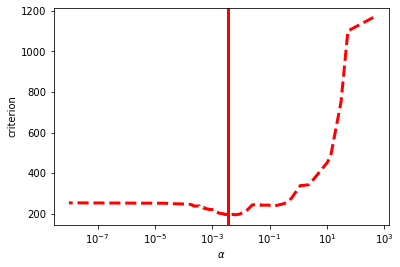

In [9]:
from sklearn.linear_model import LassoLarsCV, LassoLarsIC
EPSILON = 1e-8
model_bic = LassoLarsIC(criterion="aic", normalize=False)
model_bic.fit(X_train,Y_train)
alpha_bic_ = model_bic.alpha_
print("best alpha by BIC:",alpha_bic_)
def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(
        model.alphas_ + EPSILON,
        criterion_,
        "--",
        color=color,
        linewidth=3,
        label="%s criterion" % name,
    )
    plt.axvline(
        model.alpha_ + EPSILON,
        color=color,
        linewidth=3,
        label="alpha: %s estimate" % name,
    )
    plt.xlabel(r"$\alpha$")
    plt.ylabel("criterion")
plot_ic_criterion(model_bic, "AIC", "r")

In [10]:
print("Lasso training set scores："+str(r2_score(Y_train,model_bic.predict(X_train))))
print("Lasso testing set scores："+str(r2_score(Y_test,model_bic.predict(X_test))))

Lasso training set scores：0.886404738557078
Lasso testing set scores：0.6735067571669786


### Result 1: Choose significant predictors will slightly improve the performance of the models

## Process 2: Deal with 共线性、自回归、outliers

D:\anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1460, 52)
(1460, 48)
(1456, 48)
   MSZoning  Street  LotShape  LandContour  Utilities  LotConfig  LandSlope  \
0         3       1         3            3          0          4          0   
1         3       1         3            3          0          2          0   
2         3       1         0            3          0          4          0   
3         3       1         0            3          0          0          0   
4         3       1         0            3          0          2          0   

   Neighborhood  Condition1  Condition2  BldgType  HouseStyle  OverallQual  \
0             5           2           2         0           5            7   
1            24           1           2         0           2            6   
2             5           2           2         0           5            7   
3             6           2           2         0           5            7   
4            15           2           2         0           5            8   

   YearBuilt  YearRemod

D:\anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


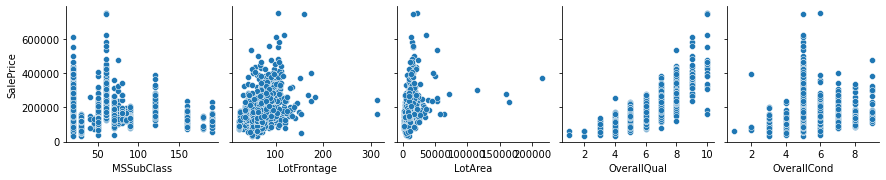

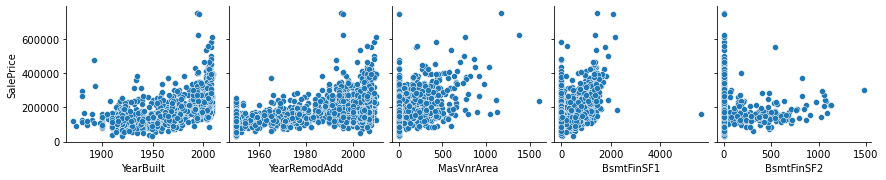

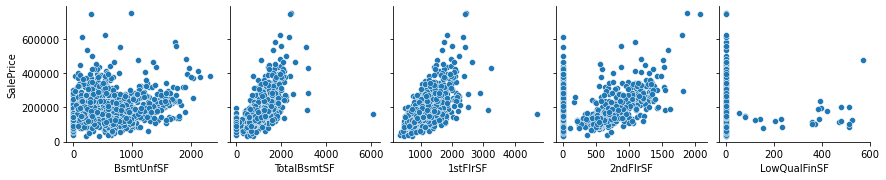

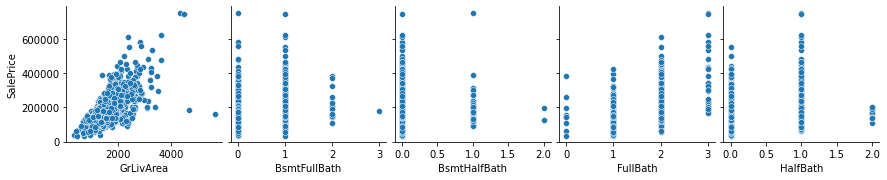

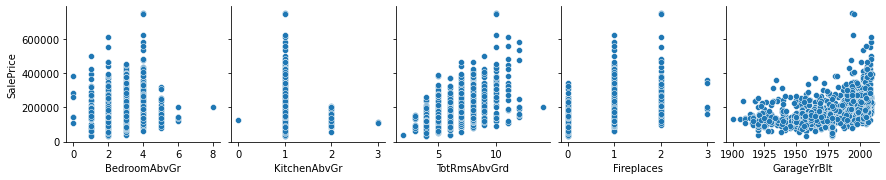

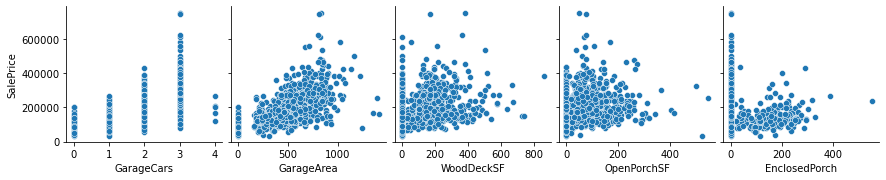

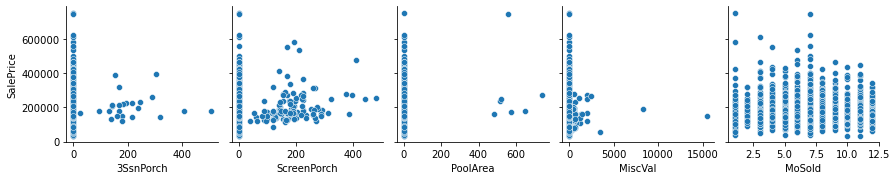

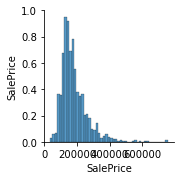

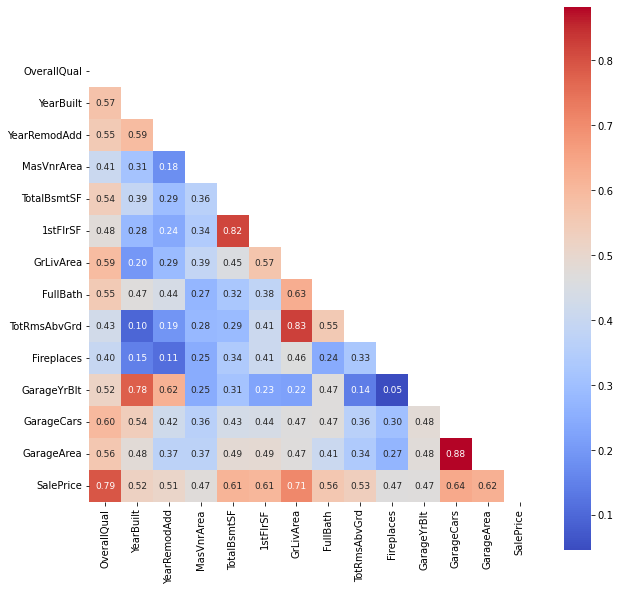

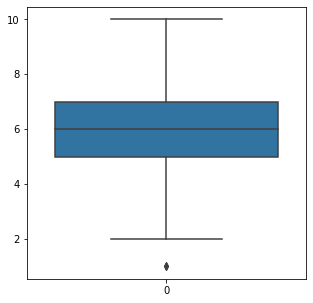

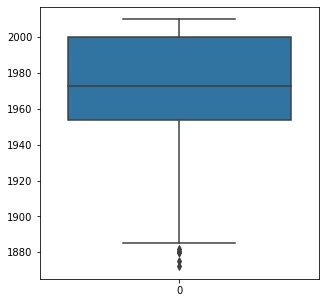

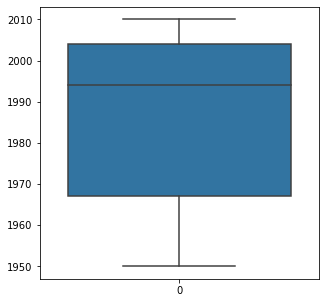

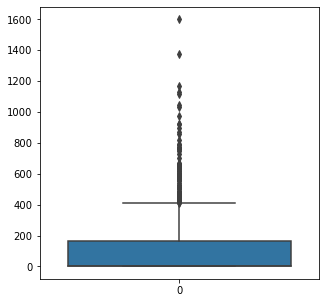

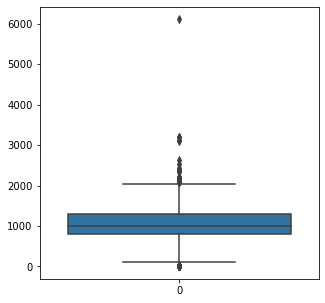

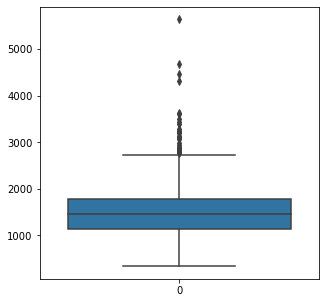

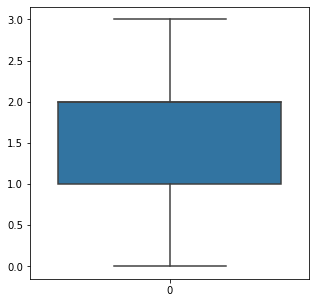

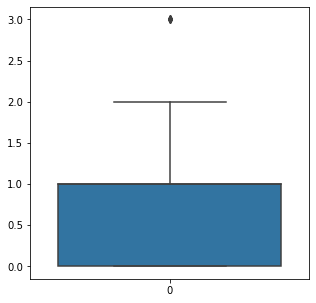

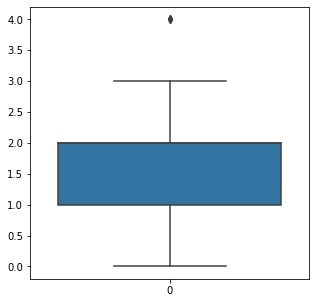

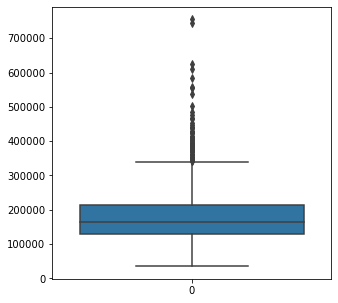

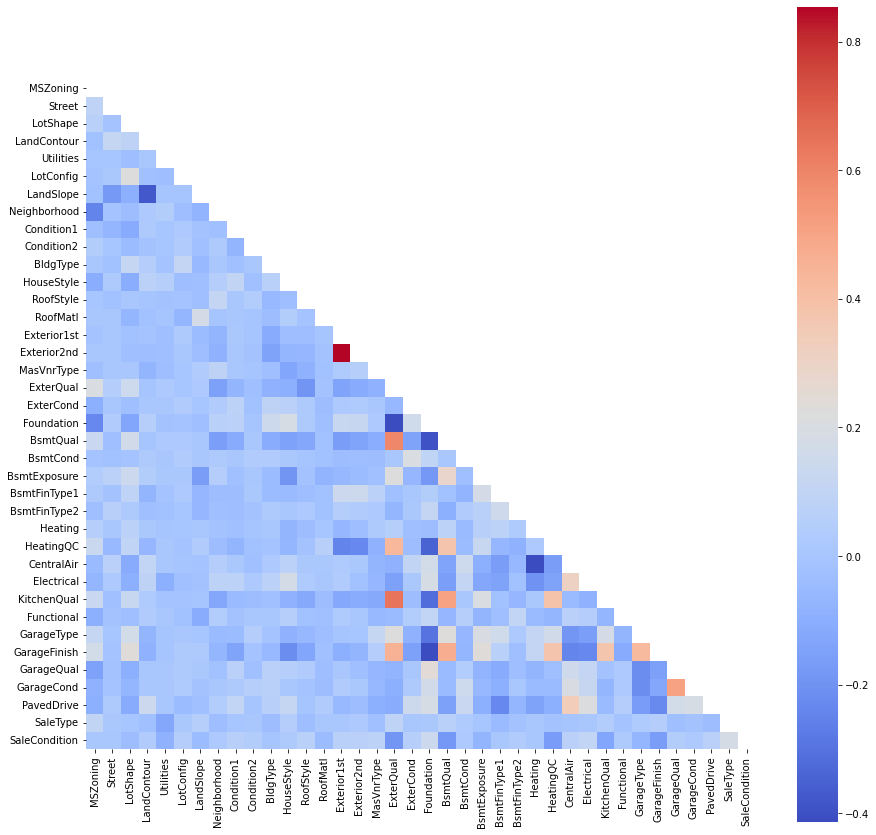

In [11]:
#this means we do need more data cleaning
#In our model, I will select only those variables whose correlation to the target is more than 0.4
num_corr_price=num_cols.corr()['SalePrice'][:-1]
for i in range(0, len(num_cols.columns), 5):
    sns.pairplot(data=num_cols, x_vars=num_cols.columns[i:i+5], y_vars=['SalePrice'])
#plt.show()
best_features=num_corr_price[abs(num_corr_price)>0.4].sort_values(ascending=False)
for feature in best_features.index:
    num_corr_price.drop(feature,inplace=True)
for feature in num_corr_price.index:
    train.drop(feature,axis=1,inplace=True)
    num_cols.drop(feature,axis=1,inplace=True)
print(train.shape)

#Besides, we should notice that some variables are highly related. I will delete one of a pair whose correlation is more than 0.7
num_corr=num_cols.corr()
corr_triu=num_corr.where(np.triu(np.ones(num_corr.shape),k=1).astype(bool))
plt.figure(figsize=(10,10))
sns.heatmap(num_corr,annot=True,square=True,fmt='.2f',annot_kws={'size':9},mask=np.triu(corr_triu),cmap="coolwarm")
#plt.show()
corr_triu_collinear = corr_triu.iloc[:-1,:-1]
collinear_features = [column for column in corr_triu_collinear.columns if any(corr_triu_collinear[column]>0.7)]
train.drop(columns=collinear_features,inplace=True)
num_cols.drop(columns=collinear_features,inplace=True)
print(train.shape)


#then delete outliers
for i in range(0,len(num_cols.columns),1):
    plt.figure(figsize=(5,5))
    sns.boxplot(data=num_cols.iloc[:,i])
#plt.show()
train=train.drop(train.MasVnrArea.sort_values(ascending = False)[:1].index)
train=train.drop(train.TotalBsmtSF.sort_values(ascending = False)[:1].index)
train=train.drop(train.GrLivArea.sort_values(ascending = False)[:2].index)
train.reset_index(drop=True,inplace=True)
print(train.shape)

#now let's deal with category variables
plt.figure(figsize=(15,15))
sns.heatmap(cat_cols.corr(),square=True,mask=np.triu(cat_cols.corr()),cmap="coolwarm")
#plt.show()

#correlated variaties
cat_corr=cat_cols.corr()
cat_corr_triu=cat_corr.where(np.triu(np.ones(cat_corr.shape),k=1).astype(bool))
cat_collinear_features=[column for column in cat_corr_triu.columns if any(cat_corr_triu[column]>0.75)]
train.drop(columns=cat_collinear_features,inplace=True)
cat_cols.drop(columns=cat_collinear_features,inplace=True)
print(train.head())
print(train.isna().sum().sort_values(ascending=False))
#let's deal with MasVnrArea
print(train.MasVnrArea.describe())
train.MasVnrArea.fillna(0,inplace=True)     #use median
print(train.shape)

### 再次使用LR建模

In [54]:
#After data preprocessing showed above, we try to do regression now.
train_std = (train-train.mean(axis=0)/train.std(axis=0))
Y = train_std['SalePrice']
X = pd.DataFrame(train_std.iloc[:,:-1])
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [55]:
X_sm_train = sm.add_constant(X_train)
res = sm.OLS(Y_train,X_sm_train).fit()
res.summary()

D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     197.3
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:46:14   Log-Likelihood:                 1779.9
No. Observations:                1164   AIC:                            -3466.
Df Residuals:                    1117   BIC:                            -3228.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -42.7661      0.482    -88.647      0.000     -43.713     -41.820
MSZoning         -0.0033      0.003     -1.174      0.241      -0.009       0.002
Street            0.0629      0.025      2.506      0.012       0.014       0.112
LotShape         -0.0033      0.001     -2.685      0.007      -0.006      -0.001
LandContour      -0.0016      0.003     -0.626      0.531      -0.007       0.003
Utilities         0.0026      0.055      0.047      0.962      -0.106       0.111
LotConfig        -0.0005      0.001     -0.531      0.595      -0.003       0.001
LandSlope         0.0175      0.006      2.736      0.006       0.005       0.030
Neighborhood  -3.339e-05      0.000     -0.117      0.907      -0.001       0.001
Condition1        0.0022      0.002      1.111      0.267      -0.002       0.006
Condition2       -0.0061      0.009     -0.674      0.500      -0.024       0.012
BldgType         -0.0080      0.001     -5.529      0.000      -0.011      -0.005
HouseStyle       -0.0013      0.001     -1.201      0.230      -0.003       0.001
OverallQual       0.0267      0.002     12.621      0.000       0.023       0.031
YearBuilt         0.0003      0.000      2.198      0.028    2.85e-05       0.001
YearRemodAdd      0.0007      0.000      5.750      0.000       0.000       0.001
RoofStyle         0.0031      0.002      1.514      0.130      -0.001       0.007
RoofMatl          0.0016      0.003      0.608      0.543      -0.004       0.007
Exterior1st      -0.0004      0.001     -0.734      0.463      -0.001       0.001
MasVnrType        0.0048      0.003      1.625      0.104      -0.001       0.010
MasVnrArea     8.912e-06   1.18e-05      0.758      0.449   -1.42e-05     3.2e-05
ExterQual         0.0019      0.004      0.523      0.601      -0.005       0.009
ExterCond         0.0032      0.002      1.399      0.162      -0.001       0.008
Foundation        0.0052      0.003      1.718      0.086      -0.001       0.011
BsmtQual         -0.0068      0.003     -2.501      0.013      -0.012      -0.001
BsmtCond          0.0031      0.003      1.142      0.254      -0.002       0.008
BsmtExposure     -0.0037      0.002     -2.349      0.019      -0.007      -0.001
BsmtFinType1     -0.0071      0.001     -7.228      0.000      -0.009      -0.005
BsmtFinType2     -0.0013      0.002     -0.729      0.466      -0.005       0.002
TotalBsmtSF    5.099e-05   5.81e-06      8.783      0.000    3.96e-05    6.24e-05
Heating           0.0038      0.006      0.631      0.528      -0.008       0.016
HeatingQC        -0.0034      0.001     -2.991      0.003      -0.006      -0.001
CentralAir        0.0563      0.008      7.083      0.000       0.041       0.072
Electrical        0.0018      0.002      1.079      0.281      -0.001       0.005
GrLivArea         0.0001    5.6e-06     19.515   

In [14]:
r2_score(Y_test,res.predict(sm.add_constant(X_test,has_constant='add')))

D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.9057751647888149

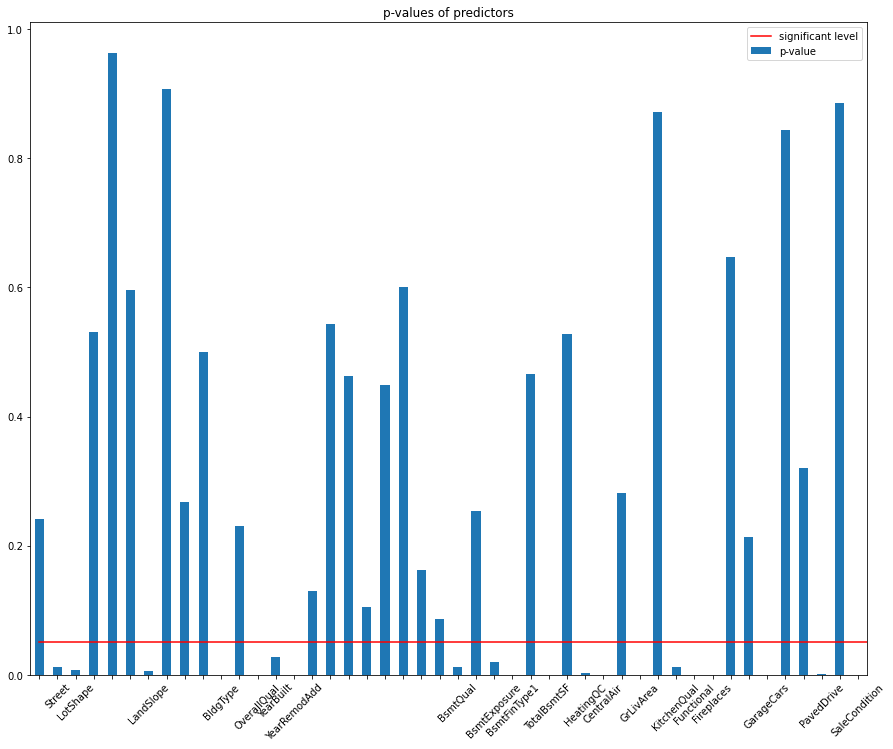

In [84]:
plt.figure(figsize=(15,12))
res.pvalues[1:].plot.bar(label='p-value')
features = res.pvalues[1:].index
pv = res.pvalues[1:].tolist()
plt.xticks(range(len(res.pvalues)-1),[features[i] if pv[i] < 0.05 else None for i in range(len(pv))],rotation=45)
plt.plot(np.linspace(0,len(pv),100),np.ones(100)*0.05,'r',label='significant level')
plt.legend()
plt.title('p-values of predictors')
plt.show()

In [89]:
sig_data_lr = X[res.params[res.pvalues<0.05].index.values[1:]].reset_index(drop=True)  # 直接改原始数据集，问题不大，换成LASSO筛选的逻辑
sig_data = X[res.params[res.pvalues<0.05].index.values[1:]].reset_index(drop=True)
X_train,X_test,Y_train,Y_test=train_test_split(sig_data,Y,test_size=0.2,random_state=0)

In [16]:
sig_lr_set = set(sig_data_lr.columns.values)

### LASSO变量筛选

In [17]:
lasso_model=LassoCV(eps=1e-9, max_iter=100)
lasso = lasso_model.fit(X_train,Y_train)
print("Lasso training set scores："+str(r2_score(Y_train,lasso_model.predict(X_train))))
print("Lasso testing set scores："+str(r2_score(Y_test,lasso_model.predict(X_test))))
coeff_lasso=pd.DataFrame(lasso.coef_,X_train.columns,columns=['Coefficient'])
print("the coef:\n",coeff_lasso)

Lasso training set scores：0.8875313528981484
Lasso testing set scores：0.9057693677731793
the coef:
                Coefficient
Street            0.009979
LotShape         -0.003522
LandSlope         0.017057
BldgType         -0.008226
OverallQual       0.026922
YearBuilt         0.000421
YearRemodAdd      0.000670
BsmtQual         -0.006513
BsmtExposure     -0.003108
BsmtFinType1     -0.007117
TotalBsmtSF       0.000054
HeatingQC        -0.003328
CentralAir        0.051928
GrLivArea         0.000109
KitchenQual      -0.007320
Functional        0.010152
Fireplaces        0.016685
GarageCars        0.022738
PavedDrive        0.012953
SaleCondition     0.011150


In [18]:
sig_data_lasso = X[coeff_lasso[coeff_lasso.Coefficient>1e-6].index].reset_index(drop=True) 
sig_data_lasso.head()

,Street,LandSlope,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,CentralAir,GrLivArea,Functional,Fireplaces,GarageCars,PavedDrive,SaleCondition
0,-14.540292,-0.225964,2.564923,1937.728876,1906.887483,853.458299,-2.783712,1706.99641,0.139536,-0.951001,-0.363274,-1.732315,0.56206
1,-14.540292,-0.225964,1.564923,1910.728876,1879.887483,1259.458299,-2.783712,1258.99641,0.139536,0.048999,-0.363274,-1.732315,0.56206
2,-14.540292,-0.225964,2.564923,1935.728876,1905.887483,917.458299,-2.783712,1782.99641,0.139536,0.048999,-0.363274,-1.732315,0.56206
3,-14.540292,-0.225964,2.564923,1849.728876,1873.887483,753.458299,-2.783712,1713.99641,0.139536,0.048999,0.636726,-1.732315,-3.43794
4,-14.540292,-0.225964,3.564923,1934.728876,1903.887483,1142.458299,-2.783712,2194.99641,0.139536,0.048999,0.636726,-1.732315,0.56206


In [19]:
sig_data_lasso.describe()

,Street,LandSlope,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,CentralAir,GrLivArea,Functional,Fireplaces,GarageCars,PavedDrive,SaleCondition
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,-14.544413,-0.163464,1.655583,1905.912255,1888.704791,1049.125881,-2.848959,1505.123471,-0.111837,-0.341111,-0.598164,-1.876546,0.333351
std,0.064084,0.276593,1.373293,30.199930,20.650976,413.765243,0.247046,502.108185,0.980917,0.641314,0.746892,0.497217,1.096962
min,-15.540292,-0.225964,-3.435077,1806.728876,1853.887483,-2.541701,-3.783712,330.996410,-5.860464,-0.951001,-2.363274,-3.732315,-3.437940
25%,-14.540292,-0.225964,0.564923,1888.728876,1870.637483,792.458299,-2.783712,1124.996410,0.139536,-0.951001,-1.363274,-1.732315,0.562060
50%,-14.540292,-0.225964,1.564923,1906.728876,1897.387483,988.458299,-2.783712,1455.496410,0.139536,0.048999,-0.363274,-1.732315,0.562060
75%,-14.540292,-0.225964,2.564923,1934.728876,1907.887483,1293.708299,-2.783712,1772.246410,0.139536,0.048999,-0.363274,-1.732315,0.562060
max,-14.540292,1.774036,5.564923,1944.728876,1913.887483,3203.458299,-2.783712,4312.996410,0.139536,2.048999,1.636726,-1.732315,1.562060


In [20]:
sig_lasso_set = set(sig_data_lasso.columns.values)

In [21]:
# sig_fwd_set = set(X_train.iloc[:,[0, 1, 6, 8, 9, 11, 12, 13, 14, 20, 22, 23, 25, 28, 30, 31, 32, 34, 38, 39, 40, 43, 45]].columns.values)

In [22]:
sig_fwd_set.intersection(sig_lasso_set)

NameError: name 'sig_fwd_set' is not defined

In [23]:
sig_lr_set.intersection(sig_lasso_set)

{'CentralAir',
 'Fireplaces',
 'Functional',
 'GarageCars',
 'GrLivArea',
 'LandSlope',
 'OverallQual',
 'PavedDrive',
 'SaleCondition',
 'Street',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

In [24]:
# X_train,X_test,Y_train,Y_test=train_test_split(sig_data_lasso,Y,test_size=0.4,random_state=10)
X_sm_train = sm.add_constant(X_train)
res = sm.OLS(Y_train,X_sm_train).fit()
res.summary()

D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     453.2
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:15:38   Log-Likelihood:                 1767.2
No. Observations:                1164   AIC:                            -3492.
Df Residuals:                    1143   BIC:                            -3386.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -43.0407      0.430   -100.083      0.000     -43.884     -42.197
Street            0.0604      0.025      2.455      0.014       0.012       0.109
LotShape         -0.0034      0.001     -2.894      0.004      -0.006      -0.001
LandSlope         0.0212      0.006      3.649      0.000       0.010       0.033
BldgType         -0.0083      0.001     -5.882      0.000      -0.011      -0.006
OverallQual       0.0268      0.002     13.088      0.000       0.023       0.031
YearBuilt         0.0004   8.74e-05      4.602      0.000       0.000       0.001
YearRemodAdd      0.0006      0.000      5.943      0.000       0.000       0.001
BsmtQual         -0.0067      0.003     -2.632      0.009      -0.012      -0.002
BsmtExposure     -0.0033      0.002     -2.175      0.030      -0.006      -0.000
BsmtFinType1     -0.0070      0.001     -7.518      0.000      -0.009      -0.005
TotalBsmtSF    5.364e-05   4.81e-06     11.158      0.000    4.42e-05    6.31e-05
HeatingQC        -0.0033      0.001     -3.022      0.003      -0.005      -0.001
CentralAir        0.0553      0.007      7.740      0.000       0.041       0.069
GrLivArea         0.0001   4.42e-06     24.537      0.000    9.99e-05       0.000
KitchenQual      -0.0078      0.003     -3.051      0.002      -0.013      -0.003
Functional        0.0105      0.002      6.179      0.000       0.007       0.014
Fireplaces        0.0170      0.003      5.853      0.000       0.011       0.023
GarageCars        0.0236      0.003      7.984      0.000       0.018       0.029
PavedDrive        0.0134      0.004      3.786      0.000       0.006       0.020
SaleCondition     0.0113      0.001      7.737      0.000       0.008       0.014
==============================================================================
Omnibus:                      262.394   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1308.934
Skew:                          -0.955   Prob(JB):                    5.87e-285
Kurtosis:                       7.831   Cond. No.                     8.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Training set score:0.8880
Test set score:0.9046
the intercept: -43.040690240517606
the coefficient:
                Coefficient
Street            0.060392
LotShape         -0.003443
LandSlope         0.021194
BldgType         -0.008255
OverallQual       0.026751
YearBuilt         0.000402
YearRemodAdd      0.000650
BsmtQual         -0.006749
BsmtExposure     -0.003304
BsmtFinType1     -0.007010
TotalBsmtSF       0.000054
HeatingQC        -0.003321
CentralAir        0.055342
GrLivArea         0.000109
KitchenQual      -0.007774
Functional        0.010528
Fireplaces        0.017029
GarageCars        0.023584
PavedDrive        0.013441
SaleCondition     0.011312
R2 predict: 0.9045919911688773


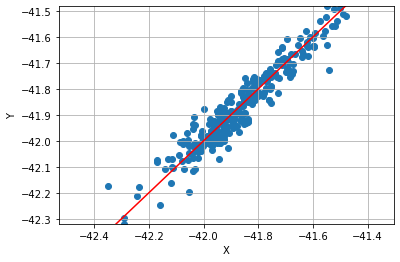

In [25]:
linreg = LinearRegression(fit_intercept=True) # 常数项理解为截距
linreg.fit(X_train,Y_train)
print("Training set score:{:.4f}".format(linreg.score(X_train,Y_train)))
print("Test set score:{:.4f}".format(linreg.score(X_test,Y_test)))
print("the intercept:",linreg.intercept_)
coeff_df=pd.DataFrame(linreg.coef_,sig_data.columns,columns=['Coefficient'])
print("the coefficient:\n",coeff_df)
pred=linreg.predict(X_test)
print("R2 predict:",r2_score(Y_test,pred))

#visualize
plt.scatter(Y_test, pred)
plt.ylabel('Y')
plt.xlabel('X')
plt.ylim([min(pred), max(pred)])
plt.xlim([min(Y), max(Y)])
plt.plot(np.arange(-100, 100, 0.1), np.arange(-100, 100, 0.1), color='red')
plt.grid()
#plt.show()


### 使用best subset选择变量

In [ ]:
import itertools

In [ ]:
# aic_list = []
# p = len(X_train.columns)
# predictors_list = []
# for k in range(1, p+1):
#     print(k)
#     for predictors in itertools.combinations(range(p), k):
#         X_train_current = X_train.iloc[:, list(predictors)]
#         X_test_current = X_test.iloc[:, list(predictors)]
#         aic = sm.OLS(X_train_current,Y_train).fit().aic
#         aic_list.append(aic)
#         predictors_list.append(predictors)
# aic_min, index = min(aic_list), aic_list.index(min(aic_list))
# print('The best subset is', predictors_list[index], 'The smallest mse is', 
# aic_min)

### 使用forwad select选择变量

In [ ]:
p = len(X_train.columns)
selected_predictors = list(range(p))
best_aic = sm.OLS(X_train, Y_train).fit().bic

while len(selected_predictors):
    print(len(selected_predictors),best_aic)
    aic_list = []
    if len(selected_predictors)==1:
        aic = sm.OLS(Y_train,X_train.iloc[:, selected_predictors]).fit().bic
        aic_list.append(aic)
    else:
        for predictors in selected_predictors:
            current_predictors = selected_predictors.copy()
            current_predictors.remove(predictors)
            X_train_current = X_train.iloc[:, current_predictors]
            X_test_current = X_test.iloc[:, current_predictors]
            aic = sm.OLS(Y_train,X_train_current).fit().bic
            aic_list.append(aic)
    aic_min, index = min(aic_list), aic_list.index(min(aic_list))
    if aic_min < best_aic:
        best_aic = aic_min
        deleted_predictor = selected_predictors[index]
        selected_predictors.remove(deleted_predictor)
    if aic_min > best_aic:
        break
    if len(selected_predictors)==1:
        break
print(selected_predictors, best_aic)

In [ ]:
def rmse_linear_reg(x_train, y_train, x_test, y_test):
    """
     This function will return the root mean square error (RMSE) on the test set 
    under the
     linear regression model fitted by the training dataset.
    :param x_train: Design matrix for training
    :param y_train: Respond variables for training
    :param x_test: Design matrix for validation
    :param y_test: Respond variables for validation
    :return: RMSE on the test dataset
    """
    model = LinearRegression(fit_intercept=False)
    model.fit(x_train, y_train)
    return mean_squared_error(y_test, model.predict(x_test), squared=False)

In [ ]:
selected_predictors = []
remaining_predictors = list(range(p))
best_rmse = rmse_linear_reg(X_train, Y_train, X_test, Y_test)
best_rmse = 10000
while len(remaining_predictors):
    rmse_list = []
    for predictors in remaining_predictors:
        current_predictors = selected_predictors.copy()
        current_predictors.append(predictors)
        X_train_current = X_train.iloc[:, current_predictors]
        X_test_current = X_test.iloc[:, current_predictors]
        rmse = rmse_linear_reg(X_train_current, Y_train, X_test_current, Y_test)
        rmse_list.append(rmse)
    rmse_min, index = min(rmse_list), rmse_list.index(min(rmse_list))
    if rmse_min < best_rmse:
        best_rmse = rmse_min
        new_predictor = remaining_predictors.pop(index)
        selected_predictors.append(new_predictor)
        print(selected_predictors, rmse_min)
    if rmse_min > best_rmse:
        break

In [ ]:
linreg = LinearRegression(fit_intercept=True) # 常数项理解为截距
linreg.fit(X_train.iloc[:,[4]],Y_train)
print("Training set score:{:.4f}".format(linreg.score(X_train.iloc[:,[4]],Y_train)))
print("Test set score:{:.4f}".format(linreg.score(X_test.iloc[:,[4]],Y_test)))
print("the intercept:",linreg.intercept_)

### 选择结束后跑LASSO, ridge

In [26]:
#LASSO and ridge
#use cv to find the best parameter
ridge_model = RidgeCV()
ridge = ridge_model.fit(X_train, Y_train)
print("ridge training set scores："+str(r2_score(Y_train,ridge_model.predict(X_train))))
print("ridge testing set scores："+str(r2_score(Y_test,ridge_model.predict(X_test))))
coeff_ridge=pd.DataFrame(ridge.coef_,sig_data.columns,columns=['Coefficient'])
lasso_model=LassoCV(eps=1e-9, max_iter=100)
lasso = lasso_model.fit(X_train,Y_train)
print("Lasso training set scores："+str(r2_score(Y_train,lasso_model.predict(X_train))))
print("Lasso testing set scores："+str(r2_score(Y_test,lasso_model.predict(X_test))))
coeff_lasso=pd.DataFrame(lasso.coef_,sig_data.columns,columns=['Coefficient'])
print("the coef:\n",coeff_lasso)

ridge training set scores：0.8875862239872019
ridge testing set scores：0.9056971252224457
Lasso training set scores：0.8875313528981484
Lasso testing set scores：0.9057693677731793
the coef:
                Coefficient
Street            0.009979
LotShape         -0.003522
LandSlope         0.017057
BldgType         -0.008226
OverallQual       0.026922
YearBuilt         0.000421
YearRemodAdd      0.000670
BsmtQual         -0.006513
BsmtExposure     -0.003108
BsmtFinType1     -0.007117
TotalBsmtSF       0.000054
HeatingQC        -0.003328
CentralAir        0.051928
GrLivArea         0.000109
KitchenQual      -0.007320
Functional        0.010152
Fireplaces        0.016685
GarageCars        0.022738
PavedDrive        0.012953
SaleCondition     0.011150


In [27]:
coeff_all = pd.DataFrame(None)
coeff_all['LR'] = coeff_df['Coefficient']
coeff_all['Ridge'] = coeff_ridge['Coefficient']
coeff_all['LASSO'] = coeff_lasso['Coefficient']
coeff_all.set_index(coeff_df.index)
coeff_all.to_csv("res_coeff.csv",index=True)

<Figure size 1440x1080 with 0 Axes>

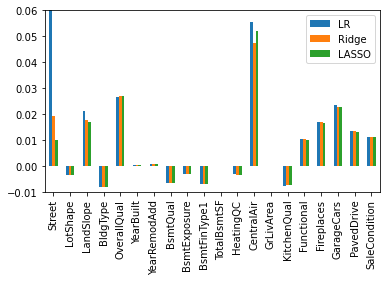

In [28]:
plt.figure(figsize=(20,15))
coeff_all.plot.bar()
plt.xticks(range(len(coeff_all)),coeff_all.index,rotation=90)
plt.ylim(-0.01,0.06)
plt.subplots_adjust(bottom=0.25)
plt.savefig('coeff.png')

### significant 变量的局部依赖性？

<AxesSubplot:>

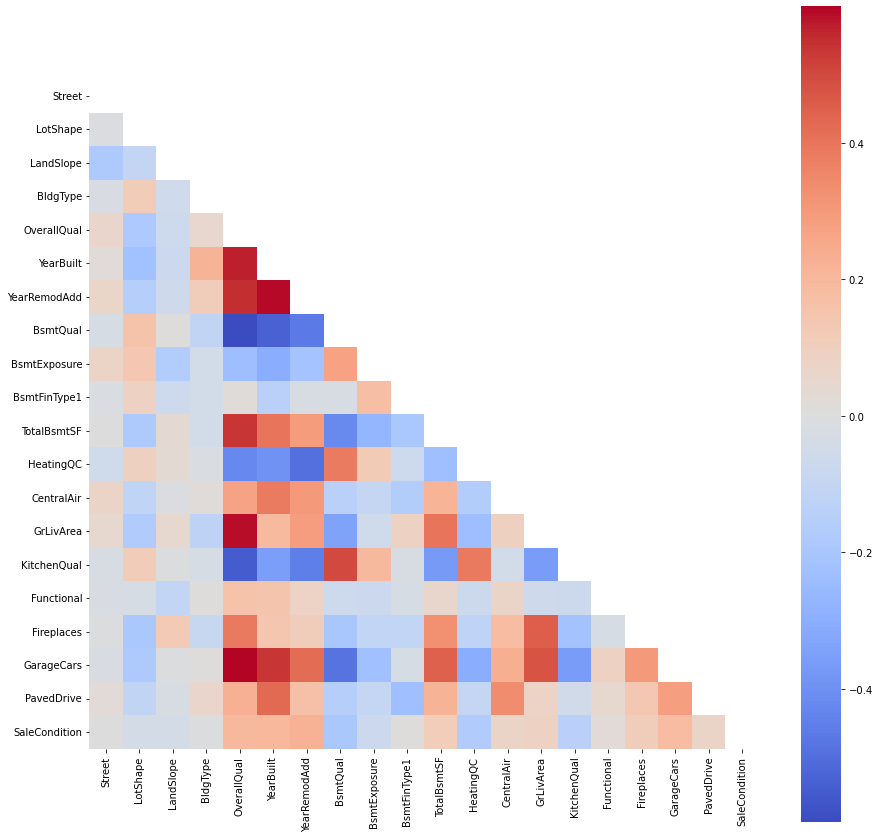

In [29]:
plt.figure(figsize=(15,15))
sns.heatmap(sig_data.corr(),square=True,mask=np.triu(sig_data.corr()),cmap="coolwarm")

####  查看residual-prediction的分布

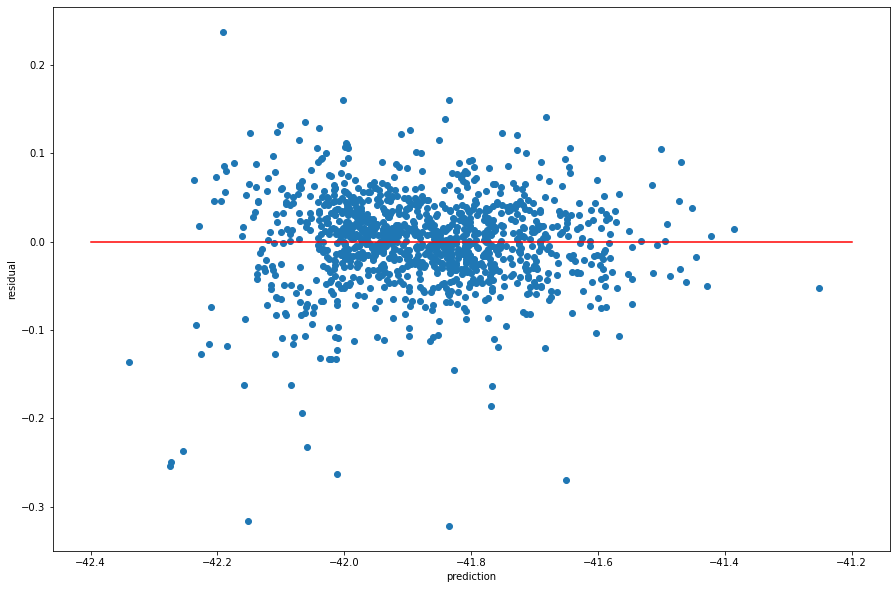

In [53]:
cob = X_train.copy()
cob['SalePrice'] = Y_train
cob['predicted'] = linreg.predict(X_train)
cob['residual'] = cob['SalePrice']-cob['predicted']
# print(cob)
# cob.to_csv('cob_data.csv',index=False)
# for i in range(0, len(cob.columns), 5):
# sns.pairplot(data=cob, x_vars=cob.columns[i:i+5], y_vars=['residual'])
plt.figure(figsize=(15,10))
# sns.pairplot(data=cob, x_vars=cob.columns[-2], y_vars=['residual'])
plt.scatter(cob.iloc[:,-2],cob.iloc[:,-1])
plt.plot(np.linspace(-42.4,-41.2,100),np.zeros(100),'r')
plt.xlabel('prediction')
plt.ylabel('residual')
plt.savefig('res.png')
plt.show()


#### 尝试poly回归检验非线性关系是否显著

In [95]:
y = Y_train.copy().reset_index(drop=True)
coefs = []
for c in X_train.columns.values:
    c1 = X_train[c].tolist()
    c2 = X_train[c].map(lambda x:x**2).tolist()
    c3 = X_train[c].map(lambda x:x**3).tolist()
    tempDF = pd.DataFrame({"X1":c1,"X2":c2,"X3":c3})
    x = sm.add_constant(tempDF)
    result = sm.OLS(y,x).fit()
    coef = np.array([result.params.values,result.pvalues.values]).reshape(-1)
    coefs.append(coef)
resd = pd.DataFrame(coefs, columns=["const_coef","x_coef","x2_coef","x3_coef","const_p","x_p","x2_p","x3_p"],index=X_train.columns.values)

D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except f

<Figure size 1080x864 with 0 Axes>

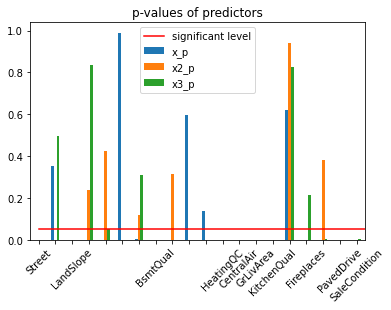

In [103]:
plt.figure(figsize=(15,12))
resd[["x_p","x2_p","x3_p"]].plot.bar(label='x p-value')
features = resd.index
pv1 = resd["x_p"].tolist()
pv2 = resd["x2_p"].tolist()
pv3 = resd["x3_p"].tolist()
plt.xticks(range(len(resd)),[features[i] if pv1[i] < 0.05 and pv2[i] < 0.05 and pv2[i] < 0.05 else None for i in range(len(pv))],rotation=45)
plt.plot(np.linspace(0,len(pv),100),np.ones(100)*0.05,'r',label='significant level')
plt.legend()
plt.title('p-values of predictors')
plt.show()

In [ ]:
resd[resd.loc[:,'x2_p']<0.05]

In [ ]:
resd.drop(resd[(resd.loc[:,'x2_p']>0.05)|(resd.loc[:,'x3_p']>0.05)].index,inplace=True)
resd[['x_p','x2_p','x3_p']]

In [ ]:
len(resd)

In [ ]:
len(sig_data.columns)

In [ ]:
# sig_data.to_csv('sig_data.csv',index=False)

## Process 3：采用数模型建模部分变量依赖

In [ ]:
# param_test2 = {'max_depth':range(2,15,3),'n_estimators':range(30,101,20),'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}
# gsearch_GBDT = GridSearchCV(estimator = GradientBoostingRegressor(random_state=0),
#                         param_grid=param_test2, scoring='r2', cv=10)
# gsearch_GBDT.fit(X_train,Y_train)
# print("Training Score:%f"%gsearch_GBDT.score(X_train,Y_train))
# print("Testing Score:%f"%gsearch_GBDT.score(X_test,Y_test))
# gsearch_GBDT.best_params_

#### Cubic polynomial 模型

In [105]:
def polize(dataset):
    data = dataset.copy()
    for c in data.columns:
        data[c+'2'] = data[c]*data[c]
        data[c+'3'] = data[c]*data[c]*data[c]
    return data

X_poly_train = polize(X_train)
X_poly_test = polize(X_test)

cubic_poly = LinearRegression()
cubic_poly.fit(X_poly_train,Y_train)
print(cubic_poly.score(X_poly_train,Y_train))
print(cubic_poly.score(X_poly_test,Y_test))
pred = cubic_poly.predict(X_poly_test)
r2_score(y_true=Y_test,y_pred=pred)

1164